# Market Segmentation Analysis using Machine Learning and Location data 


**Identifying the best location to open a new restaurant**  
*Calgary, Alberta, Canada*

Mahmood Khordoo, March 2019


## 1.Introduction
Manual site selection for business owners is still a very difficult problem. Finding the right location involves trying to quantify lots of variables that are hard to quantify and measure manually.
In this project, we will try to subvert these obstacles by combining powerful data from multiple sources such as population, business license renewal, FourSquare location API with different machine learning techniques to model the problem and try to answer these question.
The target city of the analysis is the City of Calgary located in Alberta, Canada. We believe that this approach can be used to make better decisions about where to open a new restaurant.

### 1.1 Bussiness Problem 
As mentioned before, the goal here is to help a new business owner to find the best location for its restaurant in the City of Calgary. There are several factors that could influence business success. Our focus in this study is to answer the following questions as they could potentially help a business to succeed :

  - Where should a new restaurant be located?
  - What type of restaurant would be best in a given location? 
  - How will competition down the block or across town impact market share? 

To summarize, We will use multiple data sources with different machine learning models (in particular K-mean clustering) to study the complex, dynamic, and often unobserved factors that would help to identify the best location for a new restaurant in the city.

### 1.2 City Info
Calgary, a cosmopolitan Alberta city with numerous skyscrapers, owes its rapid growth to its status as the center of Canada’s oil industry. However, it’s still steeped in the western culture that earned it the nickname “Cowtown,” evident in the Calgary Stampede. It has a population of 1.2 million people. (2016 census).


Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
import requests
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
from collections import defaultdict
from bs4 import BeautifulSoup
pd.set_option('display.expand_frame_repr',True)

*ٔNote:The codes are hidden for more readibilly.You can toggle the code display using the following botton:*

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=false; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## 2. Data Source

To build a powerful machine learning model, we needed powerful data. We will use the FourSquare API location data along with the different data sources from the web to identify the market segmentation in each part of the city.
Understanding of restaurant similarity and local food preferences are amongst the factors that we consider to be important in our site selection hypotheticals.

### 2.1 Main data sources
 - Neighbourhood boundaries in GeoJSON format([City of Calgary Open Data](https://data.calgary.ca/Base-Maps/Community-Boundaries/ab7m-fwn6)) 
 - Calgary Business Licenses Renewal ([source](https://data.calgary.ca))
 - Calgary Neighourboohd Crime data ([source](https://data.calgary.ca)) 
 - Calgary Census data-count of dwelling units and population ([source](https://data.calgary.ca)) 
 - Neighourboohd Groups based on the Postal Codes ([source](http://totallycalgary.ca/loc/) )
 - Foursquare Location API ([source](https://foursquare.com/))

We will use these data along with the explore function of the FourSquare API to get the most common venue categories in each neighborhood, and then we will use this feature to group the neighborhoods into clusters. We can then suggest the location for each business based on the locations with the most similar business. We are also considering the distance to industrial zones, population density, crimes rate and the number of renewed business licenses in our analysis.

We believe this approach can be used not only to make better decisions about where to put restaurants but could also help to identify where to put other types of businesses like general Oil and Gas or Technology offices as well. The details of the approach and analysis will be presented and discussed in the methodology section.

### 2.2 Libraries and APIs
We will use the location data from the [Foursquare](https://foursquare.com/) Location API to explore neighborhoods in Calgary.

We will also use these library convert addresses into their equivalent latitude and longitude values.

Here is a summary of location data libraries and APIs : 
- FourSquare  API
- Geopy
- Geopandas


## 2.2 Downloading the data
In order to explore the different neighborhood in Calgary we use two sources of the data: 

- Neighourhoods based on the PostalCode (Fiding Neighbourhood Names)
- Neighbourhoods based on the City classification boundaries (Finding boundaries)


This dataset for neoighbourhood names exists for free. We use the data provided in this http://totallycalgary.ca/loc/ to map the postal code to the neighbourhood name and then will map them to the neighbourhood boundaries.
### 2.2.1 Downloading the PostaCode page
We use the request library to download a page containing the postal codes and neighbourthoods of Calgary.

In [3]:
table_html=requests.get('http://totallycalgary.ca/loc/')
table_html=table_html.text

### 1.2 Parsing the HTML Table
Here we use the Beautiful Package to parse the content of the HTML options in the page and extract the required Postal code and their corresponding neighbourhood information.

In [4]:
soup=BeautifulSoup(table_html,'html.parser')
select=soup.findAll('select',{'name':"location", 'class':"location-search"})
options=BeautifulSoup(table_html,'html.parser').find_all('option')
neighbourhoods=defaultdict(list)
for row_index,option in enumerate(options):
    if row_index<=54:
        continue    
    if 'postal code' in option.text.lower():
        postal_code=option.text.strip().split()[0]
    else:
        neighbourhoods[postal_code].append(option.text.strip())
neighbourhoods
for postalcode ,neighbourhood in neighbourhoods.items():
    flatten=[','.join(neighbourhoods[postalcode])]
    neighbourhoods[postalcode]=flatten
    
neighbourhoods =pd.DataFrame.from_dict(neighbourhoods).transpose()
neighbourhoods.reset_index(inplace=True)
neighbourhoods.columns=['postalcode','neighbourhood']
neighbourhoods.sort_values(by='postalcode',inplace=True)
neighbourhoods.reset_index(inplace=True ,drop=True)
neighbourhoods.to_csv('postalcode_neighbourhoods.csv')
neighbourhoods

,postalcode,neighbourhood
0,T1Y,"Horizon,Monterey Park,Pineridge,Rundle,Sunridg..."
1,T2A,"Abbeydale,Albert Park/Radisson Heights,Applewo..."
2,T2B,"Dover,Erin Woods,South Foothills,Southview,Val..."
3,T2C,"Quarry Park,Riverbend,Shepard Industrial,Starf..."
4,T2E,"Bridgeland/Riverside,Calgary International Air..."
5,T2G,"Alyth/Bonnybrook,Downtown East Village,Golden ..."
6,T2H,"Burns Industrial,East Fairview Industrial,Fair..."
7,T2J,"Acadia,Bonavista Downs,Deer Ridge,Deer Run,Dia..."
8,T2K,"Cambrian Heights,Greenview,Highland Park,Highw..."
9,T2L,"Brentwood,Charleswood,Collingwood"


As you can see, the city of Calgary can be divided into 33 Neighbourhoods based o the postal codes.

### 2.2.1 Downloading the Neighbourhood boundaries.

The city of Calgary Open data provides the boundaries of the neighbourhoods along with some information about them in a GeoJSON file. We have already downloaded the file.

Let's load the data using the geopandas library and display a few rows.


In [5]:
communities=geopandas.read_file('Community Boundaries.geojson')
communities.head()

,comm_structure,name,sector,class_code,srg,class,comm_code,geometry
0,INNER CITY,SUNALTA,CENTRE,1,BUILT-OUT,Residential,SNA,"POLYGON ((-114.10061493005 51.047994301993, -1..."
1,BUILDING OUT,WEST SPRINGS,WEST,1,DEVELOPING,Residential,WSP,"POLYGON ((-114.187805990867 51.061506344418, -..."
2,OTHER,12A,SOUTHEAST,4,N/A,Residual Sub Area,12A,"POLYGON ((-113.869446537594 50.979572332142, -..."
3,1950s,WINDSOR PARK,CENTRE,1,BUILT-OUT,Residential,WND,"POLYGON ((-114.081517547811 51.008716296692, -..."
4,OTHER,UNIVERSITY OF CALGARY,NORTHWEST,1,BUILT-OUT,Residential,UOC,"POLYGON ((-114.141027621875 51.074356354528, -..."


Lets see how many zones we have in the City Calgary based on this data:
    

In [6]:
communities_type=pd.DataFrame(communities['class'].value_counts())
communities_type

,class
Residential,212
Residual Sub Area,48
Industrial,42
Major Park,4


As we can see the city is divided into four major zones two Residential zones along with  Industrial and Major Parks. In general, we have 260 residential neighborhoods in Calgary.

Let's plot these zones to have a better understanding of their location.

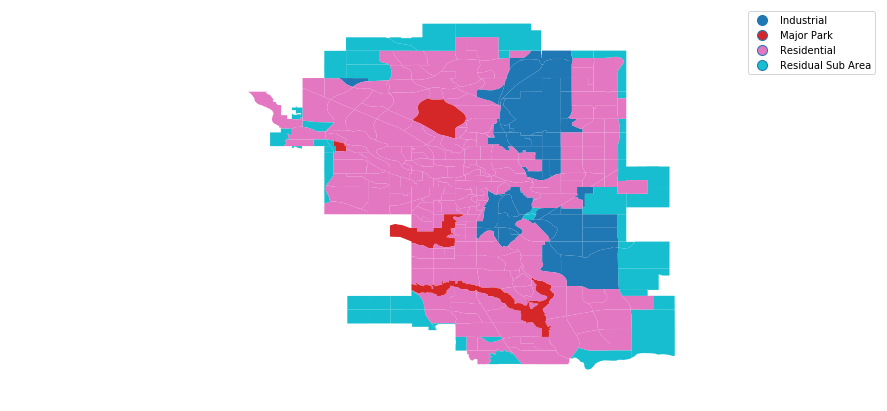

In [7]:
fig,ax=plt.subplots(figsize=(15,7))
communities.plot(column='class',ax=ax,  legend = True)
ax.set_axis_off()
plt.axis('equal');
